## Scripts to parse and plot the Training Loss and Training Accuracy

**[Adi] ToDo: I should just add a CSV/JSON logger to C++ code and use Pandas. Writing parsers is old school.**

Copyright &copy; 2019, Aditya Devarakonda
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:
    * Redistributions of source code must retain the above copyright
      notice, this list of conditions and the following disclaimer.
    * Redistributions in binary form must reproduce the above copyright
      notice, this list of conditions and the following disclaimer in the
      documentation and/or other materials provided with the distribution.
    * Neither the name of the <organization> nor the
      names of its contributors may be used to endorse or promote products
      derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL <COPYRIGHT HOLDER> BE LIABLE FOR ANY
DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import os, sys, math

def plot_loss_accuracy(sgd_logpath, casgd_logpath, svals, markers, colors, markersize):
    if not os.path.isdir(sgd_logpath):
        sys.stderr.write("option sgd_logpath is not a directory\n")

    sgd_minrt = math.inf
    casgd_minrt = math.inf
    sgd_files = [f for f in os.listdir(sgd_logpath)]
    for f in sgd_files:
        with open(sgd_logpath+f) as fp:
            for line in fp:
                if 'average' in line:
                    sgd_time = float(line[line.rfind(':')+2:line.rfind("ms")-1])
                    if sgd_time < sgd_minrt:
                        sgd_minrt = sgd_time
                        sgd_minfile = sgd_logpath+f

    loss = []
    accuracy = []
    with open(sgd_minfile) as fp:
        for line in fp:
            if 'Loss:' in line:
                loss.append(float(line[line.find('Loss:')+6:line.find(', Training')]))
            if 'Training Accuracy:' in line:
                accuracy.append(float(line[line.find('Accuracy:')+10:line.find('%')]))
            if 'elapsed' in line:
                break;
    print(len(loss))
    #plt.plot(range(1,101), loss)
    fig1, ax1 = plt.subplots();
    fig2, ax2 = plt.subplots();
    xvals = np.linspace(sgd_minrt/len(loss), sgd_minrt, num=len(loss))/1000
    ax1.plot(xvals, accuracy, 'o', label='SGD', fillstyle='none', markersize=markersize)
    ax2.plot(xvals, loss, 'o', color=colors[0], label='SGD', fillstyle='none', markersize=markersize)
    #ax2 = ax1.twinx()
    #ax2.plot(xvals, accuracy, 'r-')
    casgd_minrt = math.inf
    casgd_files = [f for f in os.listdir(casgd_logpath) if os.path.isfile(casgd_logpath + f)]

    for f in casgd_files:
        p = int(f[f.rfind('p')+1:f.rfind('_')])
        with open(casgd_logpath + f) as fp:
            for line in fp:
                if 'average' in line:
                    casgd_time = float(line[line.rfind(':')+2:line.rfind("ms")-1])
                    if casgd_time < casgd_minrt:
                        casgd_minrt = casgd_time
                        casgd_minfile = casgd_logpath+f
                        pmin = p
                        
    caloss = []
    caaccuracy = []
    
    casgd_files = [f for f in casgd_files if 'p'+str(pmin) in f]
    casgd_files = [f for f in casgd_files if int(f[f.rfind('s')+1:f.rfind('.log')]) in svals]
    casgd_files.sort(key= lambda x : int(x[x.rfind('s')+1:x.rfind('.log')]))
    #prefix = casgd_minfile[casgd_minfile.rfind('train'):casgd_minfile.rfind('s')+1]
    
    #markers = ['d', 's', '*']
    for i,f in enumerate(casgd_files):
        read = True
        s = svals[i]
        with open(casgd_logpath + f) as fp:
            caloss = []
            caaccuracy = []
            for line in fp:
                if 'Loss:' in line and read == True:
                    caloss.append(float(line[line.find('Loss:')+6:line.find(', Training')]))
                if 'Training Accuracy:' in line and read == True:
                    caaccuracy.append(float(line[line.find('Accuracy:')+10:line.find('%')]))
                if 'elapsed' in line:
                    read = False
                if 'average' in line:
                    casgd_time = float(line[line.rfind(':')+2:line.rfind("ms")-1])/1000
                    xvals = np.linspace(casgd_time/len(caloss), casgd_time, num=len(caloss))
                    ax1.plot(xvals,caaccuracy, markers[i], color=colors[i+1],
                    label='CA-SGD s = ' + str(s), fillstyle='none', markersize=markersize)
                    ax2.plot(xvals, caloss, markers[i], color=colors[i+1],
                    label = 'CA-SGD s = ' + str(s), fillstyle='none', markersize=markersize)
                    loss_diff = (np.array(loss) - np.array(caloss))
                    print('s: ' + str(s) + ', norm: ' + str(np.linalg.norm(loss_diff)))
    #xvals = np.linspace(casgd_minrt/len(caloss), casgd_minrt, num=len(caloss))/1000
    #ax1.plot(xvals, caloss, 'go')
    #ax2.plot(xvals, caaccuracy, 'r--')
    plt.rc('legend',**{'fontsize':14})
    ax2.tick_params(axis='both', labelsize=18)
    ax2.patch.set_visible(False)
    ax2.axhline(y=loss[-1], color='r', label='Final Loss: ' + str(round(loss[-1], 4)))
    ax2.set_ylabel('Training Loss', fontsize=18)
    ax2.set_xlabel('Average Running Time (sec.)', fontsize=18)
    ax2.legend()
    fig2.tight_layout()
    fig2.savefig(dset+'_loss.pdf', dpi=300, bbox_width='tight')
    
    ax1.patch.set_visible(False)
    ax1.axhline(y=accuracy[-1], color='r', label='Final Accuracy: ' + str(round(accuracy[-1],2))+'%')
    ax1.tick_params(axis='both', labelsize=18)
    ax1.set_ylabel('Training Accuracy', fontsize=18)
    ax1.set_xlabel('Average Running Time (sec.)', fontsize=18)
    ax1.legend()
    fig1.tight_layout()
    fig1.savefig(dset+'_accuracy.pdf', dpi=300, bbox_width='tight')

    #return fig

# Real-Sim Plots


['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']
100


<IPython.core.display.Javascript object>


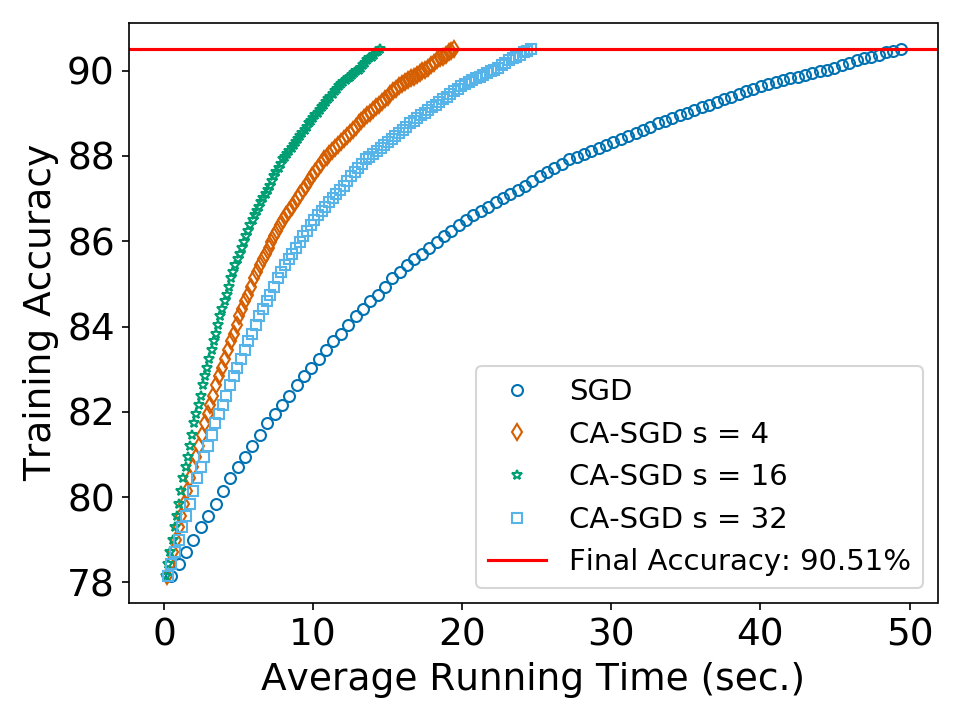

<IPython.core.display.Javascript object>


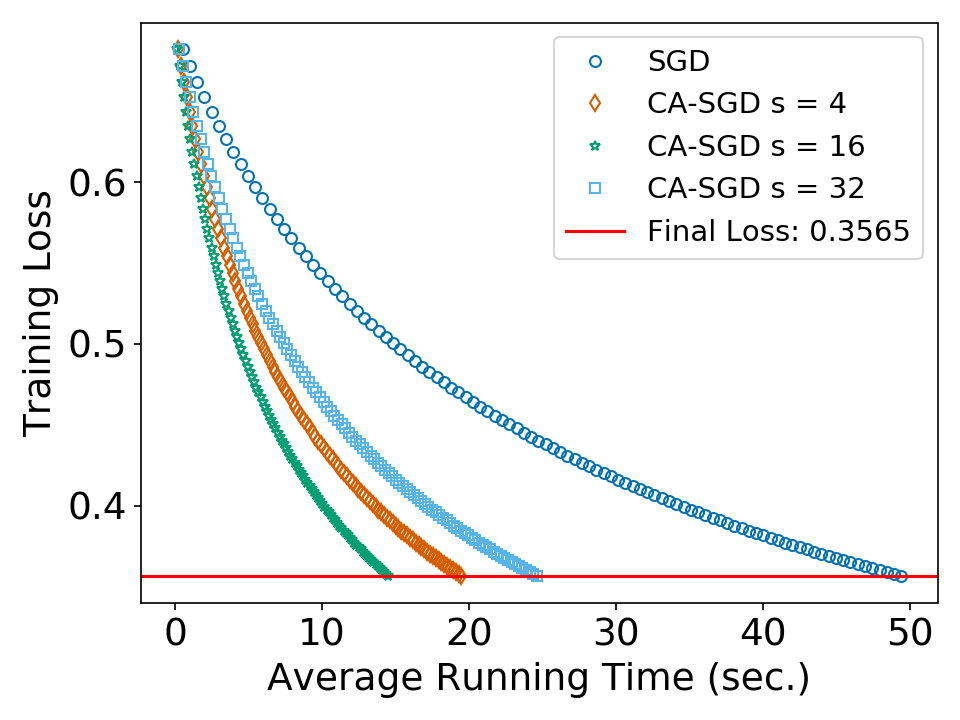

s: 4, norm: 8.15843973306311e-16
s: 16, norm: 7.850462293418876e-16
s: 32, norm: 4.509747244882934e-16


In [3]:
dset = 'realsim'
sgd_logpath = 'sample_logs/' + dset + '/sgd/'
casgd_logpath = 'sample_logs/' + dset + '/casgd/'

#print(plt.style.available)
plt.style.use('seaborn-colorblind')

svals = [4, 16, 32]
markers = ['d', '*', 's', 'p', 'X', 'v']
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(color)
color =['#0072B2', '#D55E00', '#009E73', '#56B4E9', '#CC79A7',
                 '#F0E442']
markersize = 5.25;
plot_loss_accuracy(sgd_logpath, casgd_logpath, svals, markers, color, markersize)
#fig.show()



# News20 Plots

['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']
100


<IPython.core.display.Javascript object>


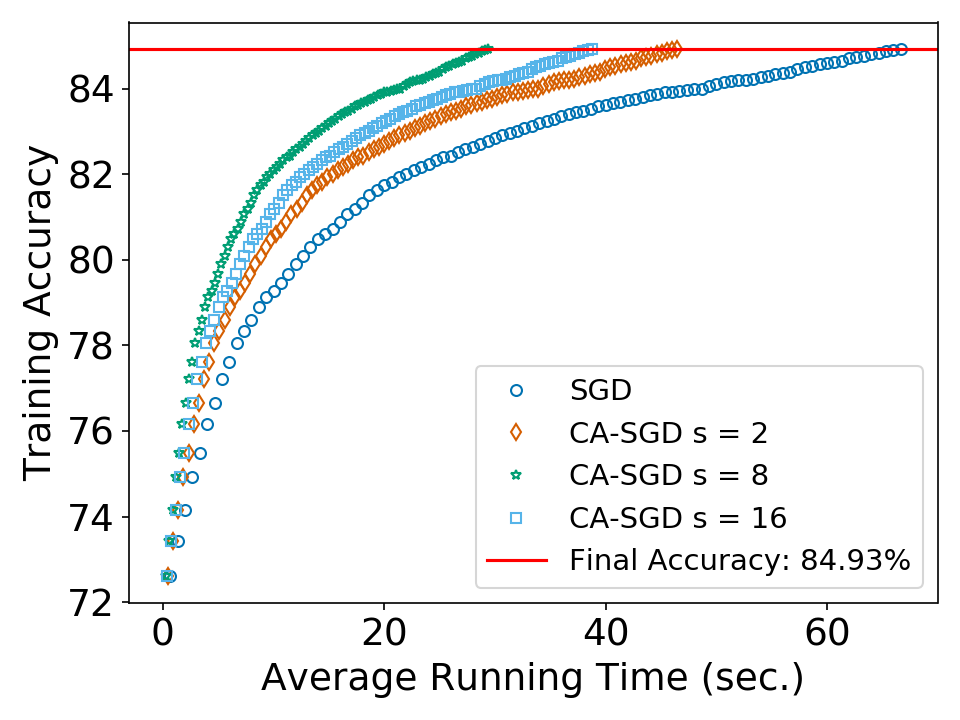

<IPython.core.display.Javascript object>


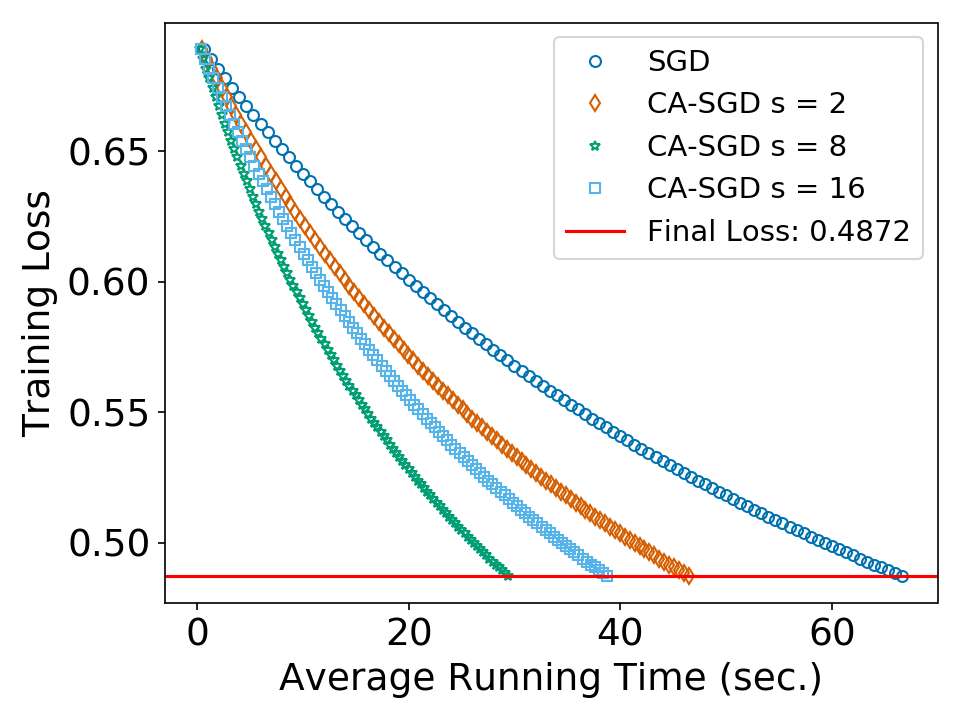

s: 2, norm: 4.611102534756203e-16
s: 8, norm: 5.382005793715205e-16
s: 16, norm: 6.977643512971218e-16


In [4]:
dset = 'news20'
sgd_logpath = 'sample_logs/' + dset + '/sgd/'
casgd_logpath = 'sample_logs/' + dset + '/casgd/'

#print(plt.style.available)
plt.style.use('seaborn-colorblind')

svals = [2, 8, 16]
markers = ['d', '*', 's', 'p', 'X', 'v']
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(color)
color =['#0072B2', '#D55E00', '#009E73', '#56B4E9', '#CC79A7',
                 '#F0E442']
markersize = 5.25;
plot_loss_accuracy(sgd_logpath, casgd_logpath, svals, markers, color, markersize)
#fig.show()



# Url Plots

['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']
100


<IPython.core.display.Javascript object>


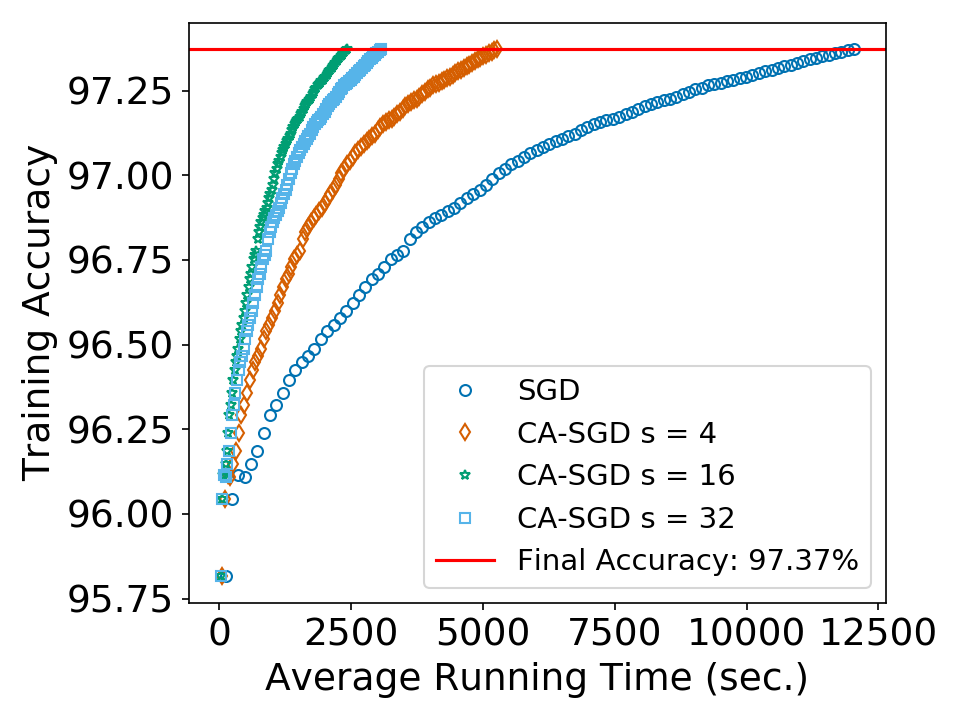

<IPython.core.display.Javascript object>


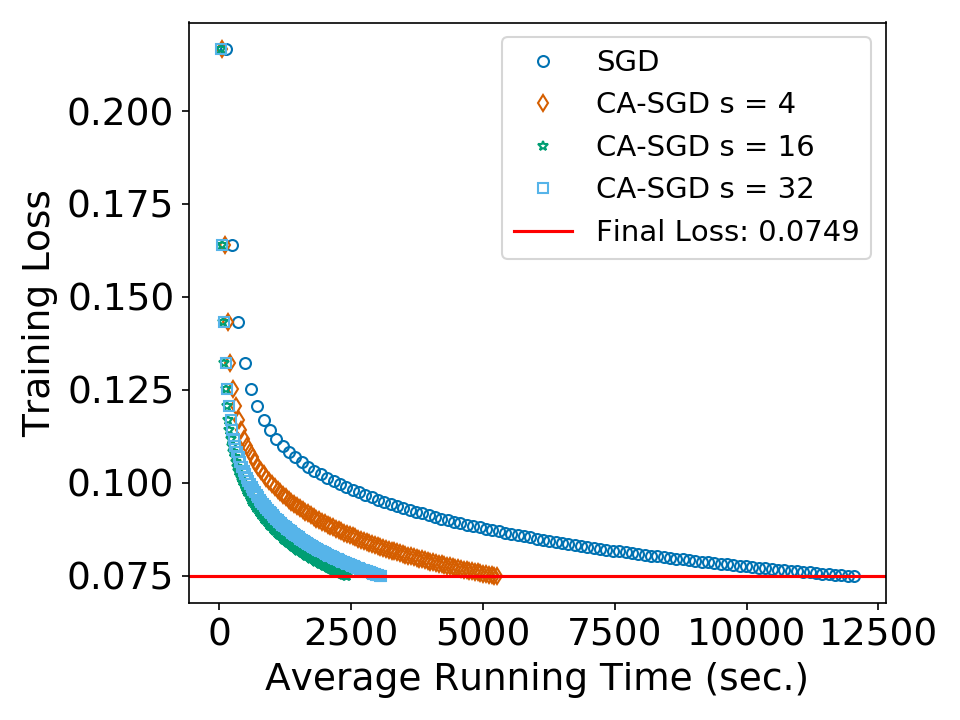

s: 4, norm: 1.4084416362486778e-16
s: 16, norm: 1.3668035872266426e-16
s: 32, norm: 2.603703785810335e-16


In [5]:
dset = 'url'

sgd_logpath = 'sample_logs/' + dset + '/sgd/'
casgd_logpath = 'sample_logs/' + dset + '/casgd/'

#print(plt.style.available)
plt.style.use('seaborn-colorblind')

svals = [4, 16, 32]
markers = ['d', '*', 's', 'p', 'X', 'v']
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(color)
color =['#0072B2', '#D55E00', '#009E73', '#56B4E9', '#CC79A7',
                 '#F0E442']
markersize = 5.25;
plot_loss_accuracy(sgd_logpath, casgd_logpath, svals, markers, color, markersize)
#fig.show()

